In [9]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader
!pip3 install torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
df = pd.read_csv('tokenized_news_articles.csv')

X = df['tokenized_content']  
y = df['gold_label'] 

label_to_index = {label: idx for idx, label in enumerate(y.unique())}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y = y.map(label_to_index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)


In [11]:
all_tokens = [token for tokens in X_train for token in eval(tokens)] 
vocabulary = list(set(all_tokens))
token_to_index = {token: idx for idx, token in enumerate(vocabulary)}  
vocab_size = len(vocabulary)  
print(f"Vocabulary size: {vocab_size}")

def tokens_to_vector(tokens, token_to_index, vocab_size):
    vector = np.zeros(vocab_size)
    for token in eval(tokens):  
        if token in token_to_index:
            vector[token_to_index[token]] += 1
    return vector

X_train_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_train])
X_test_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_test])

print(f"Training data shape: {X_train_vectors.shape}")
print(f"Test data shape: {X_test_vectors.shape}")


Vocabulary size: 10643
Training data shape: (816, 10643)
Test data shape: (351, 10643)


In [12]:
token_to_index = {token: idx for idx, token in enumerate(vocabulary)}  
vocab_size = len(vocabulary)  
print(f"Vocabulary size: {vocab_size}")

def tokens_to_vector(tokens, token_to_index, vocab_size):
    vector = np.zeros(vocab_size)
    for token in eval(tokens):  
        if token in token_to_index:
            vector[token_to_index[token]] += 1
    return vector


X_train_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_train])
X_test_vectors = np.array([tokens_to_vector(tokens, token_to_index, vocab_size) for tokens in X_test])
X_train_tfidf = X_train_vectors
X_test_tfidf = X_test_vectors

print(f"Training data shape: {X_train_vectors.shape}")
print(f"Test data shape: {X_test_vectors.shape}")


Vocabulary size: 10643
Training data shape: (816, 10643)
Test data shape: (351, 10643)


In [13]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
X_train_tensor = torch.tensor(X_train_tfidf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf, dtype=torch.float32)

In [14]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [15]:
num_classes = len(np.unique(y_train))
model = FullyConnectedNN(input_dim=X_train_tfidf.shape[1], num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
def fit_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)  # Forward pass
        loss = loss_fn(outputs, y_batch)  # Loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)

        correct_preds += (predicted == y_batch).sum().item()
        total_preds += y_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = (correct_preds / total_preds) * 100  
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        test_loss += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        correct_preds += (predicted == y_batch).sum().item()
        total_preds += y_batch.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = (correct_preds / total_preds) * 100  
    return avg_loss, accuracy

def train(model, train_loader, optimizer, loss_fn, num_epochs=100):
    train_losses = []
    train_accuracies = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = fit_one_epoch(model, train_loader, optimizer, loss_fn)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    return train_losses, train_accuracies


train_losses, train_accuracies = train(model, train_loader, optimizer, loss_fn, num_epochs=100)




Epoch 1/100
Train Loss: 1.6080, Train Accuracy: 19.12%
Epoch 2/100
Train Loss: 1.5921, Train Accuracy: 24.26%
Epoch 3/100
Train Loss: 1.5770, Train Accuracy: 31.50%
Epoch 4/100
Train Loss: 1.5600, Train Accuracy: 44.73%
Epoch 5/100
Train Loss: 1.5403, Train Accuracy: 59.19%
Epoch 6/100
Train Loss: 1.5170, Train Accuracy: 72.43%
Epoch 7/100
Train Loss: 1.4884, Train Accuracy: 81.99%
Epoch 8/100
Train Loss: 1.4543, Train Accuracy: 88.60%
Epoch 9/100
Train Loss: 1.4118, Train Accuracy: 92.52%
Epoch 10/100
Train Loss: 1.3612, Train Accuracy: 95.34%
Epoch 11/100
Train Loss: 1.3082, Train Accuracy: 96.69%
Epoch 12/100
Train Loss: 1.2424, Train Accuracy: 97.30%
Epoch 13/100
Train Loss: 1.1727, Train Accuracy: 97.79%
Epoch 14/100
Train Loss: 1.0977, Train Accuracy: 97.92%
Epoch 15/100
Train Loss: 1.0202, Train Accuracy: 97.79%
Epoch 16/100
Train Loss: 0.9403, Train Accuracy: 97.92%
Epoch 17/100
Train Loss: 0.8659, Train Accuracy: 97.92%
Epoch 18/100
Train Loss: 0.7911, Train Accuracy: 97.92%
E

In [17]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn)
print("\033[1mTest Loss: {:.4f}, Test Accuracy: {:.2f}%\033[0m".format(test_loss, test_acc))

Test Loss: 0.1809, Test Accuracy: 96.58%


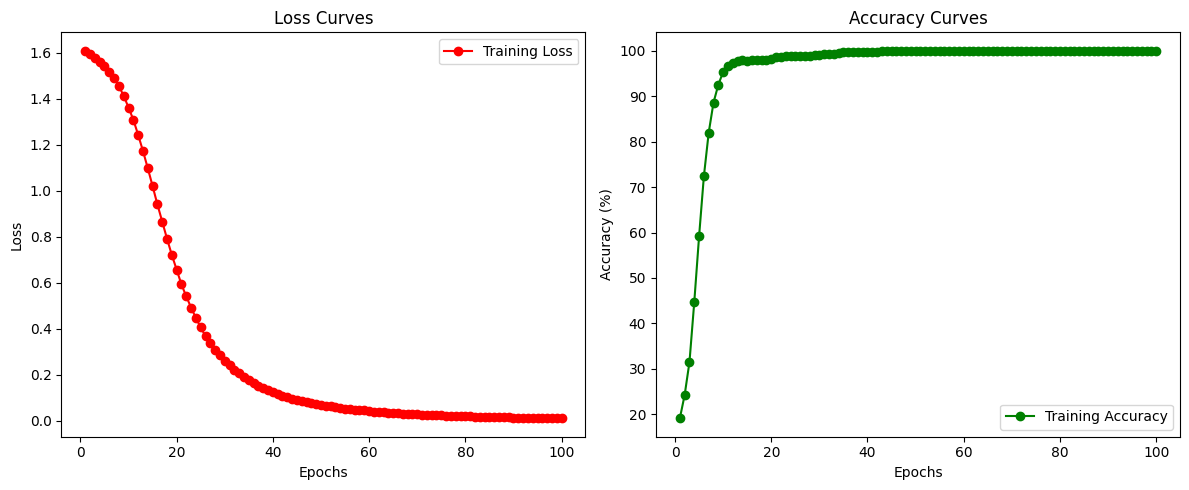

In [18]:
def plot_training_curves(history):

    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Training Loss", marker='o', color='red')
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Training Accuracy", marker='o', color='green')
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

history = {
    "train_loss": train_losses,
    "train_acc": train_accuracies,
}

plot_training_curves(history)


Classification Report:
                    precision    recall  f1-score   support

     entertainment       0.96      0.97      0.96        69
          business       1.00      0.97      0.99        72
            sports       0.97      0.95      0.96        66
science-technology       0.97      1.00      0.99        72
             world       0.93      0.93      0.93        72

          accuracy                           0.97       351
         macro avg       0.97      0.97      0.97       351
      weighted avg       0.97      0.97      0.97       351



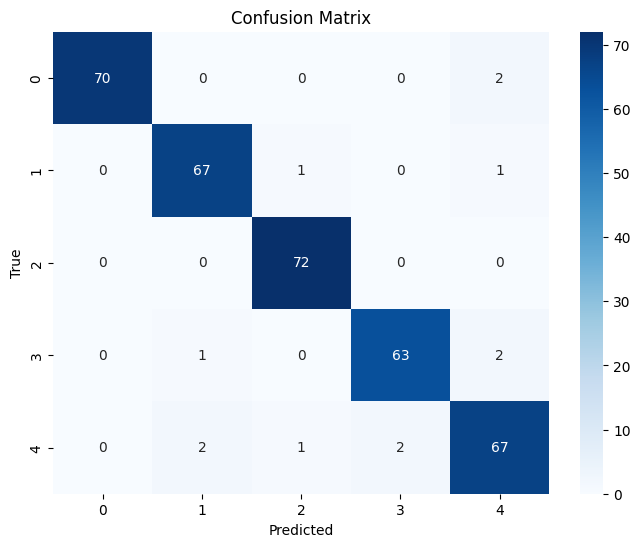

In [19]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


@torch.no_grad()
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    for X_batch, y_batch in data_loader:
       
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()
        all_preds.extend(predicted_classes)
        all_labels.extend(y_batch.cpu().numpy()) 

    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_predictions(model, test_loader)
y_true_labels = [index_to_label[idx] for idx in y_true]
y_pred_labels = [index_to_label[idx] for idx in y_pred]

# Get the list of labels (from the label_to_index mapping)
labels = list(label_to_index.keys())

# Print the classification report with actual class labels
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


COMPARISON


MLP Classifier Classification Report:
                    precision    recall  f1-score   support

     entertainment       0.96      0.97      0.96        69
          business       1.00      0.97      0.99        72
            sports       0.97      0.95      0.96        66
science-technology       0.97      1.00      0.99        72
             world       0.93      0.93      0.93        72

          accuracy                           0.97       351
         macro avg       0.97      0.97      0.97       351
      weighted avg       0.97      0.97      0.97       351



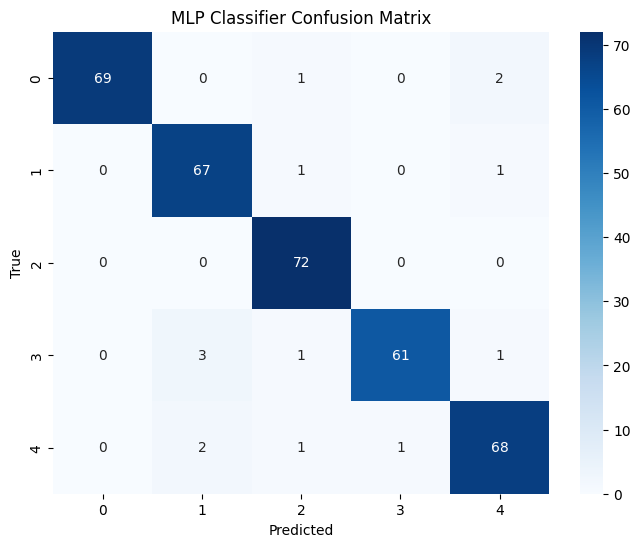

MLP Classifier Accuracy: 96.01%


In [20]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=32)
mlp_model.fit(X_train_tfidf, y_train)
y_pred_mlp = mlp_model.predict(X_test_tfidf)

print("MLP Classifier Classification Report:")
y_true_labels = [index_to_label[idx] for idx in y_true]
y_pred_labels = [index_to_label[idx] for idx in y_pred]

labels = list(label_to_index.keys())
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))

conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Classifier Confusion Matrix")
plt.show()

mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Classifier Accuracy: {mlp_accuracy * 100:.2f}%")

